In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics, costs
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from functools import partial

In [18]:
def preprocess(data, scaler):
    data = np.stack((data, np.roll(data, -1, axis=2) - data), axis=3)

    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data, data

file_name = "kdv_400_200_200_ver2"
out_name = file_name
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

c1, c2, c3 = params.T
data, raw_data = preprocess(raw_data, MaxAbsScaler)

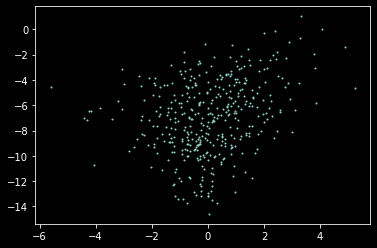

In [3]:
plt.scatter(c1,c3,s=1);

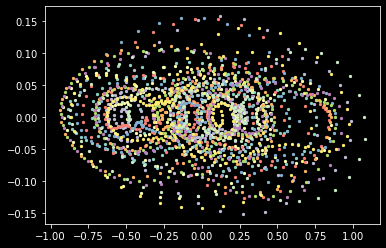

In [4]:
plt.figure()
for traj in raw_data[0,:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
# plt.axis('equal');

Distance matrix: batch 1 of 400
Distance matrix: batch 2 of 400
Distance matrix: batch 3 of 400
Distance matrix: batch 4 of 400
Distance matrix: batch 5 of 400
Distance matrix: batch 6 of 400
Distance matrix: batch 7 of 400
Distance matrix: batch 8 of 400
Distance matrix: batch 9 of 400
Distance matrix: batch 10 of 400
Distance matrix: batch 11 of 400
Distance matrix: batch 12 of 400
Distance matrix: batch 13 of 400
Distance matrix: batch 14 of 400
Distance matrix: batch 15 of 400
Distance matrix: batch 16 of 400
Distance matrix: batch 17 of 400
Distance matrix: batch 18 of 400
Distance matrix: batch 19 of 400
Distance matrix: batch 20 of 400
Distance matrix: batch 21 of 400
Distance matrix: batch 22 of 400
Distance matrix: batch 23 of 400
Distance matrix: batch 24 of 400
Distance matrix: batch 25 of 400
Distance matrix: batch 26 of 400
Distance matrix: batch 27 of 400
Distance matrix: batch 28 of 400
Distance matrix: batch 29 of 400
Distance matrix: batch 30 of 400
Distance matrix: ba

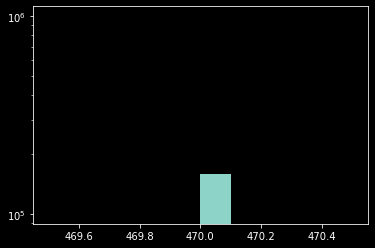

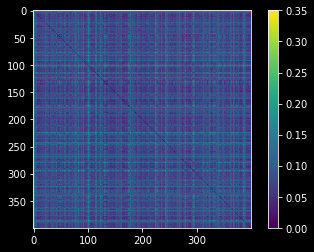

In [5]:
# cost_fn = costs.MMD(n_dims=data.shape[-1], kernel_type='gaussian', scale=0.1)
cost_fn = costs.MMD(n_dims=data.shape[-1], kernel_type='energy', p=1)
metric = partial(metrics.wasserstein_metric, cost_fn=cost_fn, geometry_type='precompute', batch_size=10)
data_flat = data.reshape(*data.shape[:-2], data.shape[-2]*data.shape[-1])
dist_mat, converged, steps = metrics.distance_matrix(data_flat, metric=metric, batch_size=20, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [5]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
# dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [11]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=100, alpha=1, robust=True)

nn_max = 0.1862049179272522
epsilon = 0.06934454292058945
mean_shift = 0.002872454159265298


(-3.341242871296413,
 3.8398723546607316,
 -2.4129341114103364,
 2.6424894834470374)

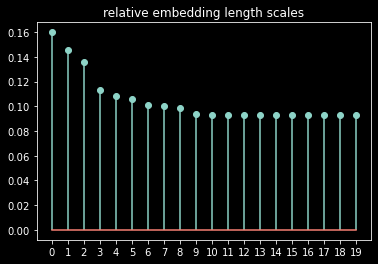

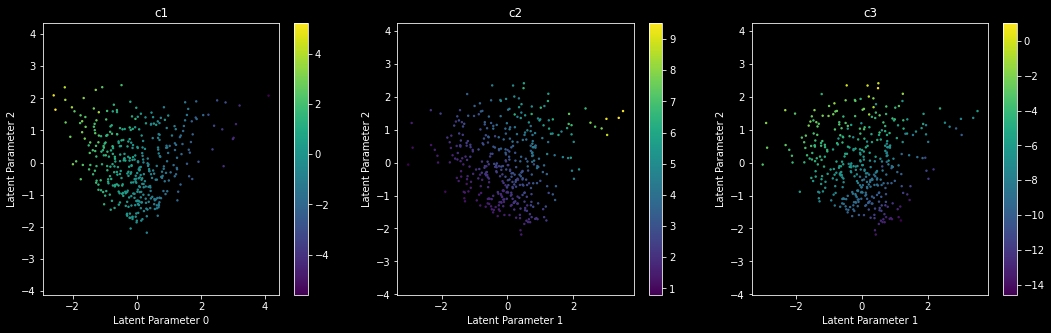

In [12]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(embedding[:,0], embedding[:,2], c=c1, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 2")
plt.title("c1")
plt.axis('equal')

plt.subplot(132)
plt.scatter(embedding[:,1], embedding[:,2], c=c2, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 1")
plt.ylabel("Latent Parameter 2")
plt.title("c2")
plt.axis('equal')

plt.subplot(133)
plt.scatter(embedding[:,1], embedding[:,2], c=c3, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 1")
plt.ylabel("Latent Parameter 2")
plt.title("c3")
plt.axis('equal')

# plt.savefig("embedding.pdf", bbox_inches='tight')

[0, 1, 2]


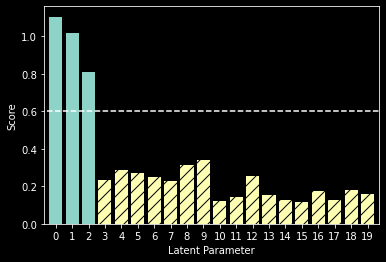

In [79]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

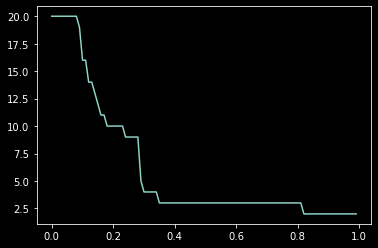

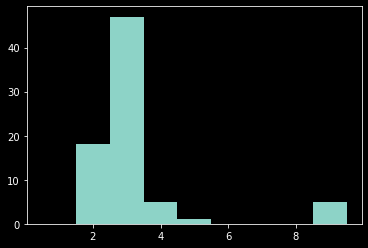

In [12]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

0.9892743817179699


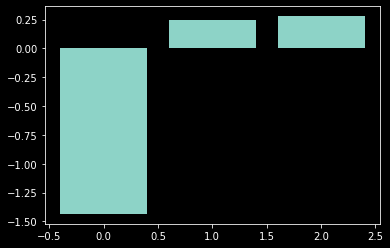

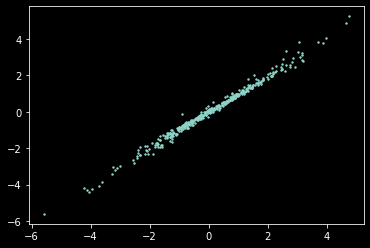

In [16]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = c1
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

kdv_400_200_200_ver2


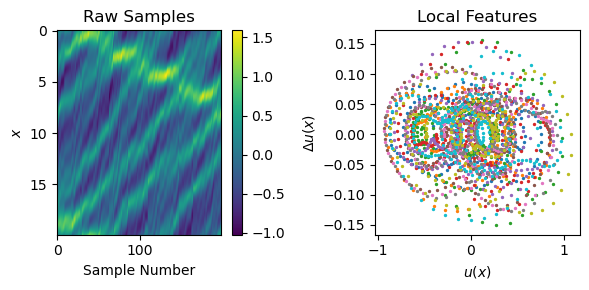

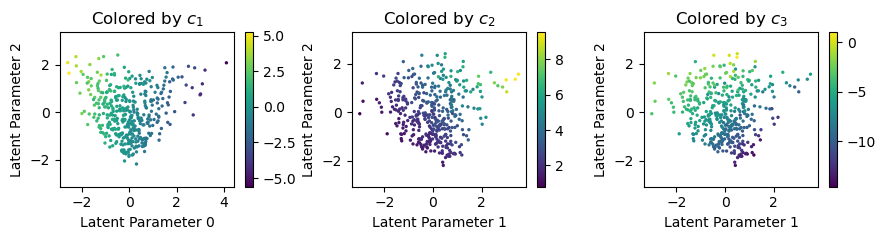

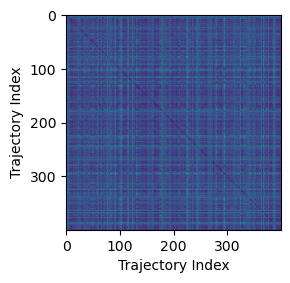

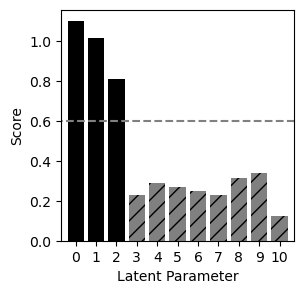

In [80]:
print(out_name)
with plt.style.context("default"):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(raw_data[0,:,:,0].T, aspect='auto')
    plt.xlabel('Sample Number')
    plt.ylabel('$x$')
    plt.yticks([0,50,100,150],[0, 5, 10, 15])
    plt.colorbar()
    plt.title("Raw Samples")

    plt.subplot(122)
    for traj in raw_data[0,:10]:
        plt.scatter(traj[:,0], traj[:,1], s=2)
    plt.xlabel("$u(x)$")
    plt.ylabel("$\Delta u(x)$")
    plt.title("Local Features")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(9,2.5))
    plt.subplot(131)
    plt.scatter(embedding[:,0], embedding[:,2], c=c1, s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $c_1$")
    plt.axis('equal')

    plt.subplot(132)
    plt.scatter(embedding[:,1], embedding[:,2], c=c2, s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 1")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $c_2$")
    plt.axis('equal')

    plt.subplot(133)
    plt.scatter(embedding[:,1], embedding[:,2], c=c3, s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 1")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $c_3$")
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()

    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 11
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(n_components)[:n_show_components])
    plt.xlim(-0.7, n_show_components - 0.3)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Latent Parameter")
    plt.hlines(threshold, -1, n_show_components, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")
